- Code looking at differences between yes/no timecourses at the earliest possible median decision point (TR=5) for coax/bill, rand yes no and all yes no

Rekha Varrier - 2021

In [1]:
# import packages, check folders
#%reset
from pathlib import Path
import os
import numpy as np
import h5py
import pandas as pd
#import imagesc as imagesc #pip install imagesc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
import pickle

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
#working_dir = os.getcwd()
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
#print('parent folder:', parent_folder)
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code


In [2]:
# setting default fontsizes for plots

s=16 # CHANGE FONTSIZE HERE

plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'



In [3]:
# vid names as saved in behavioral data

vidnames = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical", 
            "Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]

In [4]:
#loading shen atlas labels

pd.set_option('display.max_colwidth', None) # so columns are not snipped

# loading the Shen atlas labels
shen268 = pd.read_csv(os.path.join(data_file_loc,"shen_dictionary.csv"))

shen268.head()

# to print an ROI: eval(shen268[str(insert ROI val between 1-268)][0])['name']

,1,2,3,4,5,6,7,8,9,10,...,259,260,261,262,263,264,265,266,267,268
0,"{'coords': [14.083200000000005, 56.6944, -16.684799999999996], 'name': '92.80% Frontal_Pole; 7.20% Frontal_Medial_Cortex'}","{'coords': [9.599999999999994, 17.61882352941177, -19.53411764705882], 'name': '60.56% Subcallosal_Cortex; 38.73% Frontal_Orbital_Cortex'}","{'coords': [5.270633397312864, 35.03262955854126, -17.5278310940499], 'name': '58.54% Frontal_Medial_Cortex; 34.55% Subcallosal_Cortex'}","{'coords': [15.647840531561457, 34.18604651162792, -22.544850498338867], 'name': '54.15% Frontal_Pole; 41.86% Frontal_Orbital_Cortex'}","{'coords': [8.283887468030684, 46.05882352941177, -1.6700767263427139], 'name': '47.25% Paracingulate_Gyrus; 25.03% Cingulate_Gyrus_anterior_division; 16.35% Frontal_Medial_Cortex; 10.86% Frontal_Pole'}","{'coords': [14.581460674157299, 64.75280898876406, 3.682584269662925], 'name': '100.00% Frontal_Pole'}","{'coords': [30.41914191419142, 54.79537953795381, -3.3267326732673297], 'name': '100.00% Frontal_Pole'}","{'coords': [44.469325153374236, 46.095092024539866, -4.917177914110425], 'name': '99.85% Frontal_Pole'}","{'coords': [28.814814814814817, 51.163163163163176, 18.73473473473473], 'name': '100.00% Frontal_Pole'}","{'coords': [8.521081081081078, 53.28, 23.885405405405407], 'name': '48.54% Frontal_Pole; 32.43% Paracingulate_Gyrus; 19.03% Superior_Frontal_Gyrus'}",...,"{'coords': [-10.399527186761233, 10.877068557919614, -8.056737588652481], 'name': '20.66% Subcallosal_Cortex; 19.95% Left_Putamen; 19.83% Left_Accumbens; 14.40% Left_Caudate; 13.81% no_label; 5.67% Frontal_Orbital_Cortex'}","{'coords': [-14.491582491582491, -3.54882154882155, 20.909090909090907], 'name': '55.03% Left_Caudate; 29.53% Left_Lateral_Ventrical; 11.07% Left_Thalamus'}","{'coords': [-24.77079107505071, 5.537525354969574, -0.07302231237322587], 'name': '96.96% Left_Putamen'}","{'coords': [-9.427230046948353, -25.539906103286384, -1.3755868544600958], 'name': '72.56% Left_Thalamus; 21.40% Brain-Stem; 5.58% no_label'}","{'coords': [-4.68474576271187, -10.2406779661017, 5.877966101694909], 'name': '82.71% Left_Thalamus; 13.90% Left_Lateral_Ventrical'}","{'coords': [-11.407792207792212, -25.563636363636363, 14.883116883116884], 'name': '61.82% Left_Thalamus; 31.43% Left_Lateral_Ventrical'}","{'coords': [-4.821052631578951, -21.51157894736842, -15.890526315789472], 'name': '71.16% Brain-Stem; 25.89% no_label'}","{'coords': [-4.227272727272734, -37.89772727272728, -53.26704545454545], 'name': '100.00% Brain-Stem'}","{'coords': [-6.9375, -33.13068181818181, -39.34659090909091], 'name': '99.15% Brain-Stem'}","{'coords': [-5.697885196374628, -18.966767371601208, -36.81570996978852], 'name': '100.00% Brain-Stem'}"


In [5]:
responses = np.load(os.path.join(data_file_loc,'responses.npy'))
responses.shape

(1048, 10)

In [6]:
# load fmri data

#### 1. SAME MOVIE/DIFFERENT SUBJECTS ANALYSIS. run-wise normalized data, so we restore amplitude differences

print('run-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_run_norm','timecourse-all-movies_zscorenorm.npy')
tcs_run_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
print('dims:',tcs_run_z.shape)

fileName = os.path.join(data_file_loc,'timecourses_run_norm','timecourse-all-movies_maxminnorm.npy')
tcs_run_maxmin = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies


movie_ind_same = 4 # CHANGE MOVIE INDEX HERE - FOR WITHIN-MOVIE ANALYSES
print('movie: ' + str(vidnames[movie_ind_same]))
subs1 = np.where(responses[:,movie_ind_same] == 1)[0]
subs2 = np.where(responses[:,movie_ind_same] == 0)[0] 
print('nr of subs for movie:' + str(movie_ind_same) + '. Yes responders' + str(subs1.shape) + ',No responders' + str(subs2.shape))

# same movie, old version with 14 extra TRs
fileName = os.path.join(data_file_loc,'timecourses_trial_norm','timecourse-all-movies_maxminnorm_extra14TRs.npy')
tcs14_run_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies


run-wise norm data.
dims: (1048, 268, 32, 10)
movie: Random mechanical
nr of subs for movie:4. Yes responders(88,),No responders(587,)


In [7]:
#### 2. DIFFERENT MOVIES ANALYSIS
#select subs who responded "social" to the yes movie and nonsocial to the no movie

print('\ntrial-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_trial_norm','timecourse-all-movies_zscorenorm.npy')
tcs_trial_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
print('before:',tcs_trial_z.shape)

fileName = os.path.join(data_file_loc,'timecourses_trial_norm','timecourse-all-movies_maxminnorm.npy')
tcs_trial_maxmin = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies


movie_ind_yes = 0 # CHANGE MOVIE IND HERE - SOCIAL
movie_ind_no = 1 # CHANGE MOVIE IND HERE - NONSOCIAL
print('"social" movie: ' + str(vidnames[movie_ind_yes]))
print('"nonsocial" movie: ' + str(vidnames[movie_ind_no]))

subs = np.where((responses[:,movie_ind_yes] == 1)&(responses[:,movie_ind_no] == 0))[0] 
print('nr of subs with yes for movie ' + str(movie_ind_yes) + ' and no for movie ' + str(movie_ind_no) + ' =' + str(subs.shape))

tcs_trial_z = tcs_trial_z[subs,:,:,:]
tcs_trial_maxmin = tcs_trial_maxmin[subs,:,:,:]
print('after:',tcs_trial_z.shape)



trial-wise norm data.
before: (1048, 268, 32, 10)
"social" movie: COAXING-B
"nonsocial" movie: BILLIARD-A
nr of subs with yes for movie 0 and no for movie 1 =(870,)
after: (870, 268, 32, 10)


In [8]:
#### PAN-MOVIES ANALYSIS
#select subs who responded "social" to the yes movie and nonsocial to the no movie

print('\ntrial-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_trial_norm','timecourse-all-movies_zscorenorm.npy')
tcs_trial_all_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
print('before:',tcs_trial_all_z.shape)

tcs_trial_resh_yes = []
tcs_trial_resh_no = []


for m in range(10):
    tcs_trial_resh_yes.append(tcs_trial_all_z[responses[:,m]==1,:,:,m])# subsm * 268 * 32
    tcs_trial_resh_no.append(tcs_trial_all_z[responses[:,m]==0,:,:,m])# subsm * 268 * 32

tcs_trial_resh_yes = np.concatenate(tcs_trial_resh_yes,axis=0)
tcs_trial_resh_no = np.concatenate(tcs_trial_resh_no,axis=0)
print('Across movies: \n\tyes:'+ str(tcs_trial_resh_yes.shape) + ',no:' + str(tcs_trial_resh_no.shape))


trial-wise norm data.
before: (1048, 268, 32, 10)
Across movies: 
	yes:(4905, 268, 32),no:(4294, 268, 32)


In [9]:
#### PAN-MOVIES ANALYSIS MATCHED
#select subs who responded "social" to the yes movie and nonsocial to the no movie
pop_responses = [1,0,0,1,0,1,1,0,1,0]
subsList = []
for s in range(responses.shape[0]):
    if list(responses[s,:]) == pop_responses:
        subsList.append(s)
print('num subs showing pop responses:', len(subsList))

print('\ntrial-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_trial_norm','timecourse-all-movies_zscorenorm.npy')

print('before:',tcs_trial_all_z.shape)

tcs_trial_resh_yes_matched = []
tcs_trial_resh_no_matched = []


for m in range(10):
    if pop_responses[m] == 1:
        tcs_trial_resh_yes_matched.append(tcs_trial_all_z[subsList,:,:,m])# subsList * 268 * 32
    elif pop_responses[m] == 0:
        tcs_trial_resh_no_matched.append(tcs_trial_all_z[subsList,:,:,m])# subsList * 268 * 32

tcs_trial_resh_yes_matched = np.concatenate(tcs_trial_resh_yes_matched,axis=0)
tcs_trial_resh_no_matched  = np.concatenate(tcs_trial_resh_no_matched,axis=0)
print('Across movies: \n\tyes:'+ str(tcs_trial_resh_yes_matched.shape) + ',no:' + str(tcs_trial_resh_no_matched.shape))

## caution: this is still not fully matched - just that both groups have the same subjects so we know the variance is shared.
#  Each subject is repeated within a group too.
# to do: is there a better way to do this? guess this can be compared to the block analysis of multiple stimuli

num subs showing pop responses: 348

trial-wise norm data.
before: (1048, 268, 32, 10)
Across movies: 
	yes:(1740, 268, 32),no:(1740, 268, 32)


In [10]:
tr0_ind = 3 # ind at which tr=0 starts

In [11]:
from importlib import reload  
import ttests_movie_tcs as tmt # contains  ttest_diffmovies, ttest_samemovies
reload(tmt) # reload if the module/.py file is changed



<module 'ttests_movie_tcs' from '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code/on GitHub/exploration_earliest_timecourses_divergence_types/ttests_movie_tcs.py'>

## Goal - Plot how much coax vs bill, rand yes vs no and all yes vs no divergence at the earliest possible decision point (TR=4)

- at this point, at least half of the subjects would have made a decision about coax/bill (diff movies)
- decision-making would be ongoing in most other movies (all movies)
- decision would not have been reached for RAND (same movie)

## Divergence at TR decision point

In [12]:
TR = .72 #secs
'''t_secs = np.array([3.49,3.77, 13.87,6.02]) # COAX, BILL. RAND: 6.02s "no" responses, 13.87s for "yes" responses
t_TRs_ind = np.ceil((t_secs/TR)-1)
print(t_TRs_ind)
t_TRs_ind += 3 # add three to account for the prestim baseline'''

# earliest possible decision point
tr_dec = int(np.ceil((3.49/TR)-1))
print(f'earliest possible decision pt: TR {tr_dec}')

earliest possible decision pt: TR 4


In [13]:
#import plotting functions

from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain
from nilearn.plotting import plot_glass_brain
import nibabel as nib

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)


lbl = [str.upper(x[0:4]) for x in vidnames]
#lbl

In [15]:
tc1 = tcs_trial_z[:,:,tr0_ind+tr_dec,movie_ind_yes]
tc2 = tcs_trial_z[:,:,tr0_ind+tr_dec,movie_ind_no]
p = np.empty((268,))
p[:] = np.nan
mean_diff_decpt = np.nanmean(tc1-tc2,axis =0)
for n in range(268):
    _,p[n] = stats.ttest_rel(tc1[:,n],tc2[:,n],nan_policy='omit')

nodes = np.where(p>.05)[0]
#nodes = np.where(np.abs(mean_diff_decpt) > .7*np.max(np.abs(mean_diff_decpt)))[0] 
# max active regions in coax vs. bill. plotting these nodes for all tcs below
print(len(nodes),'nodes')


190 nodes


8 nodes


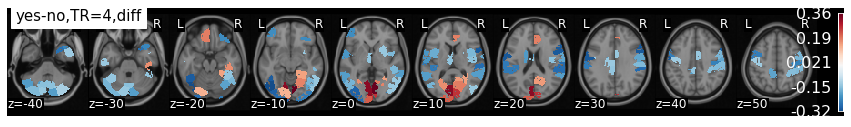

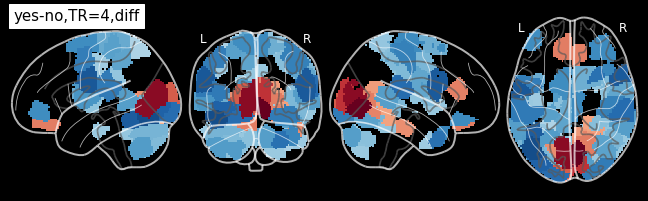

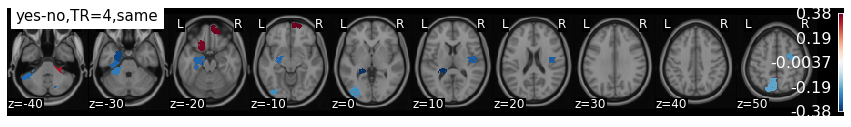

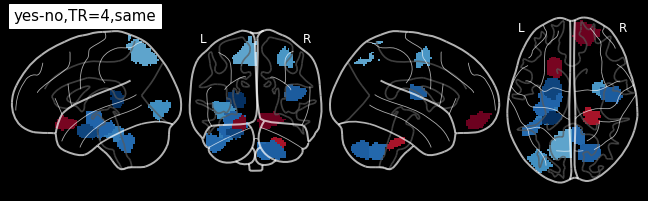

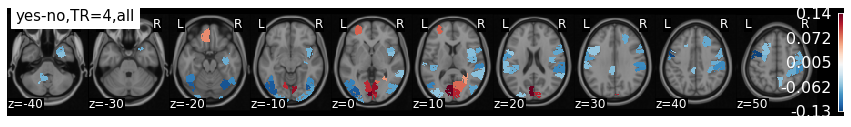

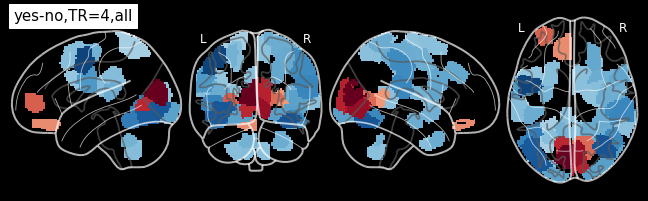

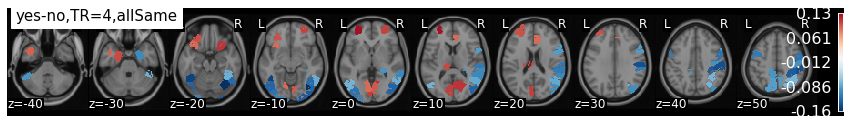

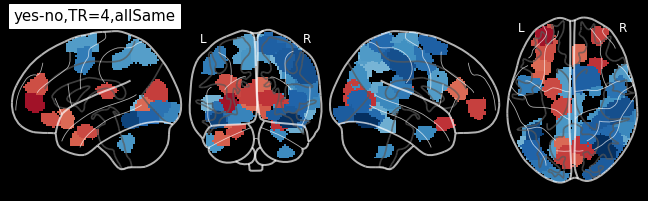

In [21]:
# plotting brainmap
#plot mean diffs at the earliest divergence point unsigned
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)
nComps = 4
mean_diff_all_during = np.empty((268,4))
mean_diff_all_during[:] = np.nan

for compType,lbl in enumerate(['diff','same','all','allSame']):
    p = np.empty((268,))
    p[:] = np.nan
    meandiff_decpt = np.zeros((268,))
    if compType ==0:
        tc1 = tcs_trial_z[:,:,tr0_ind+tr_dec,movie_ind_yes]
        tc2 = tcs_trial_z[:,:,tr0_ind+tr_dec,movie_ind_no]
        
        mean_diff_decpt = np.nanmean(tc1-tc2,axis =0)
        for n in range(268):
            _,p[n] = stats.ttest_rel(tc1[:,n],tc2[:,n],nan_policy='omit')
        
    elif compType==1:
        tc1 = tcs_run_z[subs1,:,tr0_ind+tr_dec,movie_ind_same]
        tc2 = tcs_run_z[subs2,:,tr0_ind+tr_dec,movie_ind_same]

        mean_diff_decpt = np.nanmean(tc1,axis=0)-np.nanmean(tc2,axis=0)
        for n in range(268):
            _,p[n] = stats.ttest_ind(tc1[:,n],tc2[:,n],nan_policy='omit',equal_var=False)

    elif compType==2:
        tc1 = tcs_trial_resh_yes[:,:,tr0_ind+tr_dec]
        tc2 = tcs_trial_resh_no[:,:,tr0_ind+tr_dec]
        mean_diff_decpt = np.nanmean(tc1,axis=0) - np.nanmean(tc2,axis=0)
        for n in range(268):
            _,p[n] = stats.ttest_ind(tc1[:,n],tc2[:,n],nan_policy='omit',equal_var=False)
    
    elif compType==3:
        tc1 = tcs_trial_resh_yes_matched[:,:,tr0_ind+tr_dec]
        tc2 = tcs_trial_resh_no_matched[:,:,tr0_ind+tr_dec]
        mean_diff_decpt = np.nanmean(tc1,axis=0) - np.nanmean(tc2,axis=0)
        for n in range(268):
            _,p[n] = stats.ttest_rel(tc1[:,n],tc2[:,n],nan_policy='omit')

    mean_diff_all_during[:,compType] = mean_diff_decpt
    mean_diff_decpt[p>.05] = np.nan
    img = roi_to_brain(pd.Series(mean_diff_decpt), mask_x)
    txt = f"yes-no,TR={tr_dec},{lbl}"
    img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)
    #img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
    plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                     display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')

    img.write(os.path.join(data_file_loc,'figures',f'{txt}.nii'))
    if compType == 0:
        nodes = np.where(np.abs(mean_diff_decpt) > .8*np.nanmax(np.abs(mean_diff_decpt)))[0] 
        # max active regions in coax vs. bill. plotting these nodes for all tcs below
        print(len(nodes),'nodes')
    

(0.17262750859758857, 0.004595031180716761)
(0.7449842798259813, 1.1151438312546512e-48)


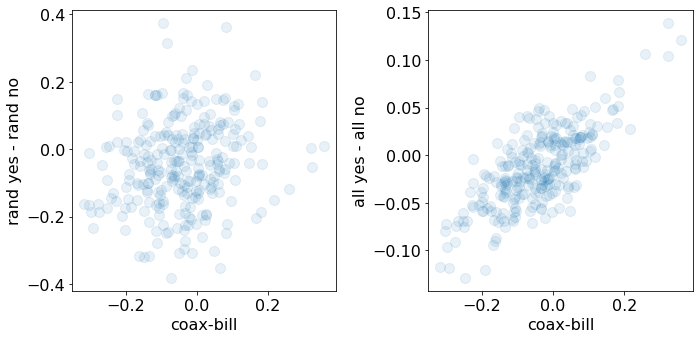

In [17]:
# plotting brainmap
#plot mean diffs at the earliest divergence point unsigned
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)
nComps = 4
mean_diff_decpt = np.empty((268,4))
mean_diff_decpt[:] = np.nan
for compType,lbl in enumerate(['diff','same','all','allSame']):
    p = np.empty((268,))
    p[:] = np.nan
    
    if compType ==0:
        tc1 = tcs_trial_z[:,:,tr0_ind+tr_dec,movie_ind_yes]
        tc2 = tcs_trial_z[:,:,tr0_ind+tr_dec,movie_ind_no]
        
        mean_diff_decpt[:,0] = np.nanmean(tc1-tc2,axis =0)
        for n in range(268):
            _,p[n] = stats.ttest_rel(tc1[:,n],tc2[:,n],nan_policy='omit')
        
    elif compType==1:
        tc1 = tcs_run_z[subs1,:,tr0_ind+tr_dec,movie_ind_same]
        tc2 = tcs_run_z[subs2,:,tr0_ind+tr_dec,movie_ind_same]

        mean_diff_decpt[:,1] = np.nanmean(tc1,axis=0)-np.nanmean(tc2,axis=0)
        for n in range(268):
            _,p[n] = stats.ttest_ind(tc1[:,n],tc2[:,n],nan_policy='omit',equal_var=False)

    elif compType==2:
        tc1 = tcs_trial_resh_yes[:,:,tr0_ind+tr_dec]
        tc2 = tcs_trial_resh_no[:,:,tr0_ind+tr_dec]
        mean_diff_decpt[:,2] = np.nanmean(tc1,axis=0) - np.nanmean(tc2,axis=0)
        for n in range(268):
            _,p[n] = stats.ttest_ind(tc1[:,n],tc2[:,n],nan_policy='omit',equal_var=False)
    
    elif compType==3:
        tc1 = tcs_trial_resh_yes_matched[:,:,tr0_ind+tr_dec]
        tc2 = tcs_trial_resh_no_matched[:,:,tr0_ind+tr_dec]
        mean_diff_decpt[:,3] = np.nanmean(tc1,axis=0) - np.nanmean(tc2,axis=0)
        for n in range(268):
            _,p[n] = stats.ttest_rel(tc1[:,n],tc2[:,n],nan_policy='omit')

    #mean_diff_decpt[p>.05,compType] = np.nan

plt.figure(1,figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(mean_diff_decpt[:,0],mean_diff_decpt[:,1],marker='o',s=100,alpha=0.1)
plt.xlabel('coax-bill')
plt.ylabel('rand yes - rand no')
plt.subplot(1,2,2)
plt.scatter(mean_diff_decpt[:,0],mean_diff_decpt[:,2],marker='o',s=100,alpha=0.1)
plt.xlabel('coax-bill')
plt.ylabel('all yes - all no')
plt.tight_layout()
print(stats.pearsonr(mean_diff_decpt[:,0],mean_diff_decpt[:,1]))#,nan_policy='omit'))
print(stats.pearsonr(mean_diff_decpt[:,0],mean_diff_decpt[:,2]))#,nan_policy='omit'))

In [18]:
#plot timecourses for earliest divergence point unsigned


from textwrap import wrap

nComps = 4
for compType,lbl in enumerate(['diff','same','all','allSame']):

    meandiff_decpt = np.zeros((268,))
    if compType ==0:
        tc1 = tcs_trial_z[:,:,:,movie_ind_yes]
        tc2 = tcs_trial_z[:,:,:,movie_ind_no]
        mean_diff_decpt = np.nanmean(tcs_trial_z[:,:,tr0_ind+tr_dec,movie_ind_yes]-
                                     tcs_trial_z[:,:,tr0_ind+tr_dec,movie_ind_no],axis =0)
        
    elif compType==1:
        tc1 = tcs_run_z[subs1,:,:,movie_ind_same]
        tc2 = tcs_run_z[subs2,:,:,movie_ind_same]
        mean_diff_decpt = np.nanmean(tcs_run_z[subs1,:,tr0_ind+tr_dec,movie_ind_same],axis=0)-\
                            np.nanmean(tcs_run_z[subs2,:,tr0_ind+tr_dec,movie_ind_same],axis=0)

    elif compType==2:
        tc1 = tcs_trial_resh_yes
        tc2 = tcs_trial_resh_no
        mean_diff_decpt = np.nanmean(tc1[:,:,tr0_ind+tr_dec],axis=0)-\
                            np.nanmean(tc2[:,:,tr0_ind+tr_dec],axis=0)
    
    elif compType==3:
        tc1 = tcs_trial_resh_yes_matched
        tc2 = tcs_trial_resh_no_matched
        mean_diff_decpt = np.nanmean(tc1[:,:,tr0_ind+tr_dec],axis=0)-\
                            np.nanmean(tc2[:,:,tr0_ind+tr_dec],axis=0)
        
    
    if compType == 0:
        nodes = np.where(np.abs(mean_diff_decpt) > .5*np.max(np.abs(mean_diff_decpt)))[0] 
        print('threshold=',str(.6*np.max(np.abs(mean_diff_decpt))))
        # max active regions in coax vs. bill. plotting these nodes for all tcs below
        print(len(nodes),'nodes')
    
    f=0
    for i,n in enumerate(nodes):
        f += 1
        roi = eval(shen268[str(int(n+1))][0])['name'].split(';')
        title_str = 'Node '+ str(n+1) + ',' + ','.join(roi)
        #title_str = "\n".join(wrap(title_str, 100))
        if str.lower(title_str).find('cing'):
            print(title_str)
        #print(n+1,roi)
        

threshold= 0.2151595171384783
38 nodes
Node 17,66.67% Frontal_Pole, 32.63% Frontal_Orbital_Cortex
Node 21,63.51% Precentral_Gyrus, 33.67% Inferior_Frontal_Gyrus_pars_opercularis
Node 23,59.68% Postcentral_Gyrus, 36.99% Precentral_Gyrus
Node 24,75.89% Precentral_Gyrus, 11.78% Postcentral_Gyrus, 8.22% Juxtapositional_Lobule_Cortex_(formerly_Supplementary_Motor_Cortex)
Node 33,79.75% Postcentral_Gyrus, 20.25% Precentral_Gyrus
Node 46,30.14% Parietal_Operculum_Cortex, 28.13% Planum_Temporale, 14.65% Supramarginal_Gyrus_posterior_division, 13.38% Supramarginal_Gyrus_anterior_division, 7.69% Superior_Temporal_Gyrus_posterior_division
Node 51,99.23% Temporal_Pole
Node 52,99.80% Temporal_Pole
Node 65,51.09% Middle_Temporal_Gyrus_temporooccipital_part, 26.64% Supramarginal_Gyrus_posterior_division, 12.90% Angular_Gyrus, 6.04% Superior_Temporal_Gyrus_posterior_division
Node 67,54.07% Occipital_Fusiform_Gyrus, 28.60% Lateral_Occipital_Cortex_inferior_division, 14.90% Temporal_Occipital_Fusiform_C

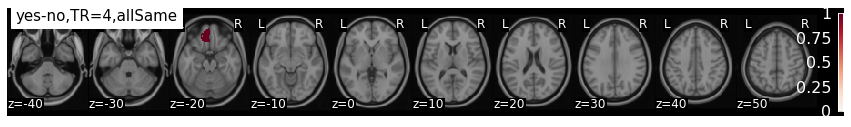

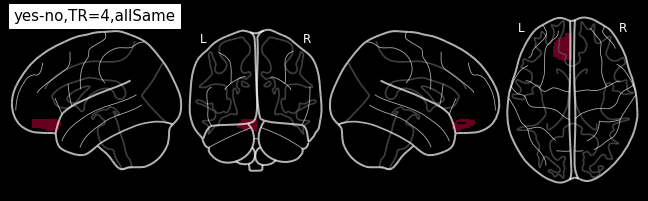

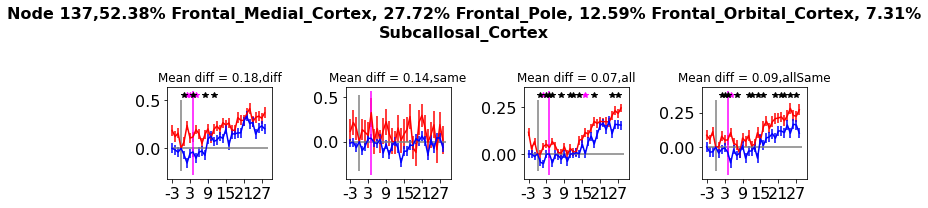

In [171]:
# plot a region's timcourses in each analysis

n = 136
nodes = np.empty((268,))
nodes[:] = np.nan
nodes[n] = 1
img = roi_to_brain(pd.Series(nodes), mask_x)
txt = f"yes-no,TR={tr_dec},{lbl}"
img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                    display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')

plt.figure(3,figsize = (10,3))
roi = eval(shen268[str(int(n+1))][0])['name'].split(';')
title_str = 'Node '+ str(n+1) + ',' + ','.join(roi)
title_str = "\n".join(wrap(title_str, 100))
plt.suptitle(title_str,fontsize = 16,fontweight = 'bold')
   
'''if len(title_str) <=100:
    title_str = title_str + '\n'
elif len(title_str) <=200:
    title_str = title_str + '\n'''
#plt.title('Node '+ str(n+1))

for compType,lbl in enumerate(['diff','same','all','allSame']):
    
    plt.subplot(1,nComps,compType+1)

    if compType == 0:
        tc1 = tcs_trial_z[:,:,:,movie_ind_yes]
        tc2 = tcs_trial_z[:,:,:,movie_ind_no]
        tmt.ttest_diffmovies(tc1[:,n,:],tc2[:,n,:],1,'both',0,tr0_ind)
        mean_diff_decpt = np.nanmean(tcs_trial_z[:,:,tr0_ind+tr_dec,movie_ind_yes]-
                                            tcs_trial_z[:,:,tr0_ind+tr_dec,movie_ind_no],axis =0)
        

    elif compType == 1:
        tc1 = tcs_run_z[subs1,:,:,movie_ind_same]
        tc2 = tcs_run_z[subs2,:,:,movie_ind_same]
        tmt.ttest_samemovies(tc1[:,n,:],tc2[:,n,:],1,'both',0,tr0_ind)
        mean_diff_decpt = np.nanmean(tcs_run_z[subs1,:,tr0_ind+tr_dec,movie_ind_same],axis=0)-\
                                    np.nanmean(tcs_run_z[subs2,:,tr0_ind+tr_dec,movie_ind_same],axis=0)
    
    elif compType == 2:
        tc1 = tcs_trial_resh_yes
        tc2 = tcs_trial_resh_no
        tmt.ttest_samemovies(tc1[:,n,:],tc2[:,n,:],1,'both',0,tr0_ind)
        mean_diff_decpt = np.nanmean(tc1[:,:,tr0_ind+tr_dec],axis=0)-\
                                    np.nanmean(tc2[:,:,tr0_ind+tr_dec],axis=0)
        plt.title(f'Mean diff = {str(np.round(mean_diff_decpt[n],2))},{lbl}',fontsize = 12)

    elif compType == 3:
        tc1 = tcs_trial_resh_yes_matched
        tc2 = tcs_trial_resh_no_matched
        tmt.ttest_samemovies(tc1[:,n,:],tc2[:,n,:],1,'both',0,tr0_ind)
        mean_diff_decpt = np.nanmean(tc1[:,:,tr0_ind+tr_dec],axis=0)-\
                                    np.nanmean(tc2[:,:,tr0_ind+tr_dec],axis=0)
    
    plt.title(f'Mean diff = {str(np.round(mean_diff_decpt[n],2))},{lbl}',fontsize = 12)
     
    #print(n+1,roi)
    ymin,ymax =plt.ylim()
    plt.vlines(tr_dec+tr0_ind,ymin,ymax,color = 'magenta')
    if compType==3:
        plt.tight_layout()

15 nodes


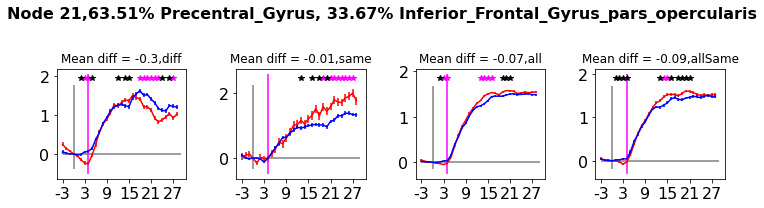

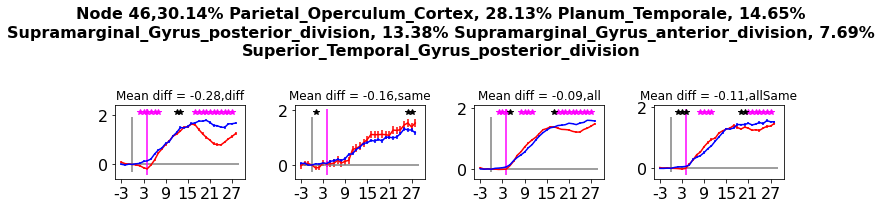

In [22]:
#plot timecourses for earliest divergence point unsigned

nComps = 4
for compType,lbl in enumerate(['diff','same','all','allSame']):

    meandiff_decpt = np.zeros((268,))
    if compType ==0:
        tc1 = tcs_trial_z[:,:,:,movie_ind_yes]
        tc2 = tcs_trial_z[:,:,:,movie_ind_no]
        mean_diff_decpt = np.nanmean(tcs_trial_z[:,:,tr0_ind+tr_dec,movie_ind_yes]-
                                     tcs_trial_z[:,:,tr0_ind+tr_dec,movie_ind_no],axis =0)
        
    elif compType==1:
        tc1 = tcs_run_z[subs1,:,:,movie_ind_same]
        tc2 = tcs_run_z[subs2,:,:,movie_ind_same]
        mean_diff_decpt = np.nanmean(tcs_run_z[subs1,:,tr0_ind+tr_dec,movie_ind_same],axis=0)-\
                            np.nanmean(tcs_run_z[subs2,:,tr0_ind+tr_dec,movie_ind_same],axis=0)

    elif compType==2:
        tc1 = tcs_trial_resh_yes
        tc2 = tcs_trial_resh_no
        mean_diff_decpt = np.nanmean(tc1[:,:,tr0_ind+tr_dec],axis=0)-\
                            np.nanmean(tc2[:,:,tr0_ind+tr_dec],axis=0)
    
    elif compType==3:
        tc1 = tcs_trial_resh_yes_matched
        tc2 = tcs_trial_resh_no_matched
        mean_diff_decpt = np.nanmean(tc1[:,:,tr0_ind+tr_dec],axis=0)-\
                            np.nanmean(tc2[:,:,tr0_ind+tr_dec],axis=0)
        
    
    if compType == 0:
        nodes = np.where(np.abs(mean_diff_decpt) > .7*np.max(np.abs(mean_diff_decpt)))[0] 
        # max active regions in coax vs. bill. plotting these nodes for all tcs below
        print(len(nodes),'nodes')
    
    f=0
    for i,n in enumerate(nodes[:2]): # CHANGE NODES HERE
        f += 1
        plt.figure(f,figsize = (10,3))
        roi = eval(shen268[str(int(n+1))][0])['name'].split(';')
        title_str = 'Node '+ str(n+1) + ',' + ','.join(roi)
        title_str = "\n".join(wrap(title_str, 100))
        '''if len(title_str) <=100:
            title_str = title_str + '\n'
        elif len(title_str) <=200:
            title_str = title_str + '\n'''
        #plt.title('Node '+ str(n+1))
        if compType ==0:
            plt.subplot(1,nComps,1)
            tmt.ttest_diffmovies(tc1[:,n,:],tc2[:,n,:],1,'both',0,tr0_ind)
        elif compType ==1:
            plt.subplot(1,nComps,2)
            tmt.ttest_samemovies(tc1[:,n,:],tc2[:,n,:],1,'both',0,tr0_ind)
        elif compType ==2:
            plt.subplot(1,nComps,3)
            tmt.ttest_samemovies(tc1[:,n,:],tc2[:,n,:],1,'both',0,tr0_ind)
        elif compType ==3:
            plt.subplot(1,nComps,4)
            tmt.ttest_samemovies(tc1[:,n,:],tc2[:,n,:],1,'both',0,tr0_ind)
        
        plt.suptitle(title_str,fontsize = 16,fontweight = 'bold')
        
        #print(n+1,roi)
        plt.title(f'Mean diff = {str(np.round(mean_diff_decpt[n],2))},{lbl}',fontsize = 12)
        ymin,ymax =plt.ylim()
        plt.vlines(tr_dec+tr0_ind,ymin,ymax,color = 'magenta')
        if compType==3:
            plt.tight_layout()

## Pre-decision AUC

In [23]:
# pre-decision AUC

mean_diff_all = []
mean_diff_aucs = np.empty((268,4))
mean_diff_aucs [:] = np.nan

#tr_dec =5

for compType,lbl in enumerate(['diff','same','all','allSame']):
    
    for n in range(268):
        if compType == 0:
            if n==0:
                p = np.empty((268,))
                p[:] = np.nan
            tc1 = tcs_trial_z[:,n,:int(tr0_ind+tr_dec),movie_ind_yes]
            tc2 = tcs_trial_z[:,n,:int(tr0_ind+tr_dec),movie_ind_no]

        elif compType == 1:
            tc1 = tcs_run_z[subs1,n,:int(tr0_ind+tr_dec),movie_ind_same]
            tc2 = tcs_run_z[subs2,n,:int(tr0_ind+tr_dec),movie_ind_same]
            
        
        elif compType == 2:
            tc1 = tcs_trial_resh_yes[:,n,:int(tr0_ind+tr_dec)]
            tc2 = tcs_trial_resh_no[:,n,::int(tr0_ind+tr_dec)]
            
        elif compType == 3:
            tc1 = tcs_trial_resh_yes_matched[:,n,:int(tr0_ind+tr_dec)]
            tc2 = tcs_trial_resh_no_matched[:,n,:int(tr0_ind+tr_dec)]
        

        auc1 = np.array([np.trapz(tc1[s,:]) for s in range(tc1.shape[0])])
        auc2 = np.array([np.trapz(tc2[s,:]) for s in range(tc2.shape[0])])
        if compType == 0:
            _,p[n] = stats.ttest_rel(auc1,auc2)

        if compType in [0,3]:
            mean_diff_aucs[n,compType] = np.nanmean(auc1-auc2)
        else:
            mean_diff_aucs[n,compType] = np.nanmean(auc1)-np.nanmean(auc2)
    
    if compType == 0:
        nodes = np.where(p<.05)[0]
        
    mean_diff_aucs[~nodes] = np.nan
    mean_diff_aucs

coax-bill: SpearmanrResult(correlation=0.5125997000933078, pvalue=5.098890038109398e-18)
rand: SpearmanrResult(correlation=0.6213135157844385, pvalue=7.1127155352026595e-28)


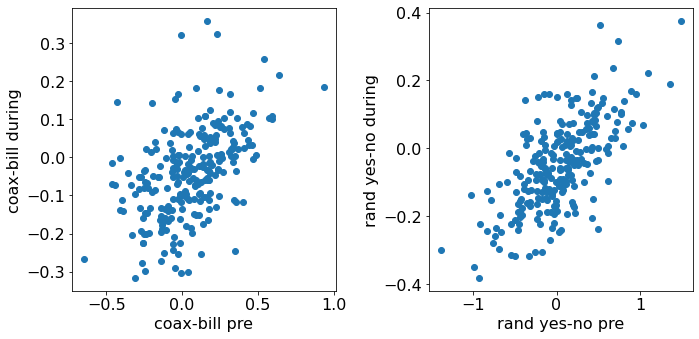

In [32]:
plt.figure(1,figsize=(10,5))

plt.subplot(121)
plt.scatter(mean_diff_aucs[:,0],mean_diff_all_during[:,0])
print("coax-bill:",stats.spearmanr(mean_diff_aucs[:,0],mean_diff_all_during[:,0],nan_policy='omit'))
plt.xlabel('coax-bill pre')
plt.ylabel('coax-bill during')

plt.subplot(122)
plt.scatter(mean_diff_aucs[:,1],mean_diff_all_during[:,1])
print("rand:",stats.spearmanr(mean_diff_aucs[:,1],mean_diff_all_during[:,1],nan_policy='omit'))
plt.xlabel('rand yes-no pre')
plt.ylabel('rand yes-no during')

plt.tight_layout()

- The analysis above shows that the nodes which showed a higher yes-no difference before also shows the difference during  (at TR=4) - so the differences at TR=4 for is a reasonable indicator of nodes involved in early decision-making. This could be useful because we see below that correlating pre yes-no between analyses isn't significant, and few regions show the difference (is this correct? check again!)

SpearmanrResult(correlation=0.07932893910761236, pvalue=0.213159372777428)


SpearmanrResult(correlation=-0.17440660474716202, pvalue=0.488838709959337)

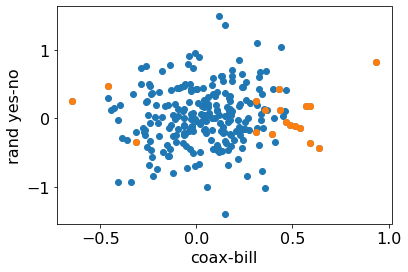

In [261]:
plt.scatter(mean_diff_aucs[:,0],mean_diff_aucs[:,1])
print(stats.spearmanr(mean_diff_aucs[:,0],mean_diff_aucs[:,1],nan_policy='omit'))
plt.xlabel('coax-bill')
plt.ylabel('rand yes-no')

plt.scatter(mean_diff_aucs[nodes,0],mean_diff_aucs[nodes,1])
stats.spearmanr(mean_diff_aucs[nodes,0],mean_diff_aucs[nodes,1],nan_policy='omit')

SpearmanrResult(correlation=0.02090771339242303, pvalue=0.7431933981478801)


SpearmanrResult(correlation=0.16821465428276572, pvalue=0.5046325110850312)

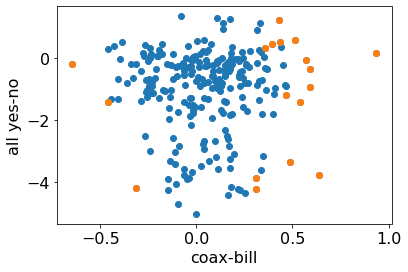

In [263]:
plt.scatter(mean_diff_aucs[:,0],mean_diff_aucs[:,2])
print(stats.spearmanr(mean_diff_aucs[:,0],mean_diff_aucs[:,2],nan_policy='omit'))
plt.xlabel('coax-bill')
plt.ylabel('all yes-no')

plt.scatter(mean_diff_aucs[nodes,0],mean_diff_aucs[nodes,2])
stats.spearmanr(mean_diff_aucs[nodes,0],mean_diff_aucs[nodes,2],nan_policy='omit')

node: 0
node: 50
node: 100
node: 150
node: 200
node: 250
sig nodes: 20
nr of nodes: 7


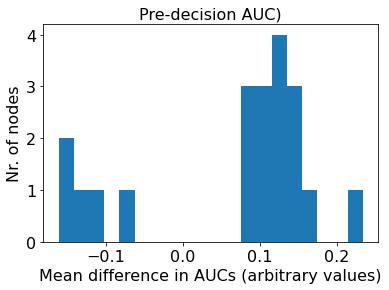

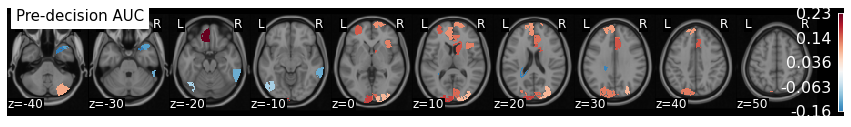

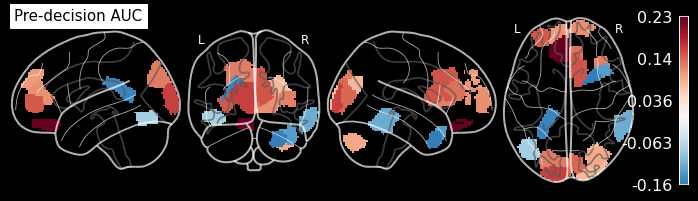

In [196]:
# pre-decision AUC
#DIFF MOVIES 
#mean_diff_all = []
mean_diff = np.empty((268,))
mean_diff [:] = np.nan
p  = np.empty_like(mean_diff)
p[:] = np.nan
#tr_dec =5

for n in range(268):
    if n % 50 ==0:
        print('node:',n)
    
    tc1 = tcs_trial_z[:,n,:int(tr0_ind+tr_dec),movie_ind_yes]
    tc2 = tcs_trial_z[:,n,:int(tr0_ind+tr_dec),movie_ind_no]
    auc1 = np.array([np.trapz(tc1[s,:]) for s in range(tc1.shape[0])])
    auc2 = np.array([np.trapz(tc2[s,:]) for s in range(tc2.shape[0])])
    mean_diff[n] = np.nanmean(auc1-auc2)
    _,p[n] = stats.ttest_rel(auc1,auc2)
    
mean_diff = mean_diff
mean_diff[p>.05] = np.nan  
print('sig nodes:',len(np.where(~np.isnan(mean_diff))[0]))

plt.hist(mean_diff,bins=20)
plt.xlabel('Mean difference in AUCs (arbitrary values)')
plt.ylabel('Nr. of nodes')
plt.title('Pre-decision AUC)')

img = roi_to_brain(pd.Series(mean_diff), mask_x)
txt = f"Pre-decision AUC"
img.plot(colorbar=True, title = txt,symmetric_cbar = False,cmap = 'RdBu_r')
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,colorbar=True,
                 display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')

nodes = np.where(np.abs(mean_diff)>.6*np.nanmax(np.abs(mean_diff)))[0]
print('nr of nodes:',len(nodes))

#mean_diff_all.append(['diff',mean_diff])


In [198]:
mean_diff_all[1]

IndexError: list index out of range

node: 0
node: 50
node: 100
node: 150
node: 200
node: 250
nr of nodes: 14


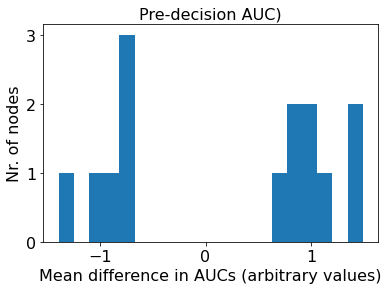

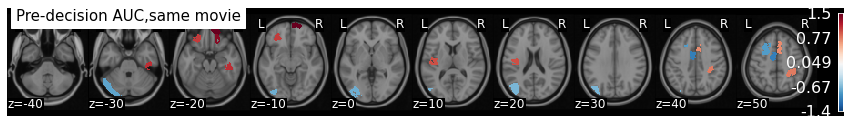

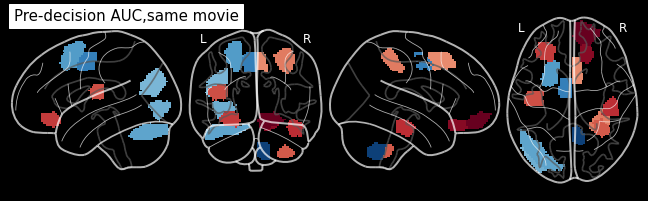

In [199]:
# pre-decision AUC
#SAME MOVIES 
mean_diff = np.empty((268,))
mean_diff [:] = np.nan
p  = np.empty_like(mean_diff)
p[:] = np.nan
#tr_dec =8

for n in range(268):
    if n % 50 ==0:
        print('node:',n)
    
    tc1 = tcs_run_z[subs1,n,:int(tr0_ind+tr_dec),movie_ind_same]
    tc2 = tcs_run_z[subs2,n,:int(tr0_ind+tr_dec),movie_ind_same]
    auc1 = [np.trapz(tc1[s,:]) for s in range(tc1.shape[0])]
    auc2 = [np.trapz(tc2[s,:]) for s in range(tc2.shape[0])]
    mean_diff[n] = np.nanmean(auc1)-np.nanmean(auc2)
    _,p[n] = stats.ttest_ind(auc1,auc2)            

mean_diff = mean_diff
mean_diff_all.append(['same',mean_diff])
mean_diff[p>.05] = np.nan  
print('nr of nodes:',len(np.where(p<=.05)[0]))   

plt.hist(mean_diff,bins=20)
plt.xlabel('Mean difference in AUCs (arbitrary values)')
plt.ylabel('Nr. of nodes')
plt.title('Pre-decision AUC)')


img = roi_to_brain(pd.Series(mean_diff), mask_x)
txt = f"Pre-decision AUC,same movie"
img.plot(colorbar=True, title = txt,symmetric_cbar = False,cmap = 'RdBu_r')
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                 display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')



node: 0
node: 50
node: 100
node: 150
node: 200
node: 250
nr of nodes: 7


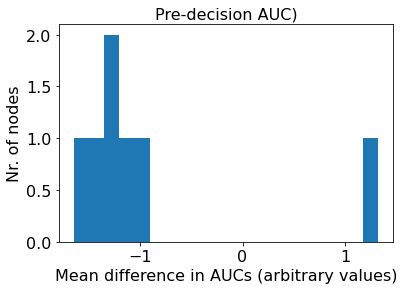

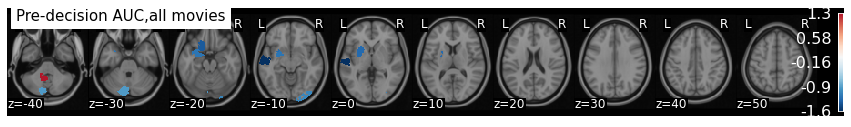

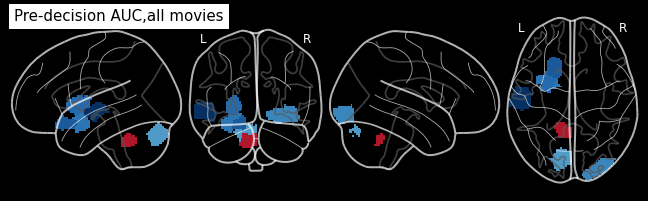

In [202]:
# pre-decision AUC
#all MOVIES 
mean_diff = np.empty((268,))
mean_diff [:] = np.nan
p  = np.empty_like(mean_diff)
p[:] = np.nan
#tr_dec =8

for n in range(268):
    if n % 50 ==0:
        print('node:',n)
    
    tc1 = tcs_trial_resh_yes[subs1,n,:int(tr0_ind+tr_dec)]
    tc2 = tcs_trial_resh_no[subs2,n,:int(tr0_ind+tr_dec)]
    auc1 = [np.trapz(tc1[s,:]) for s in range(tc1.shape[0])]
    auc2 = [np.trapz(tc2[s,:]) for s in range(tc2.shape[0])]
    mean_diff[n] = np.nanmean(auc1)-np.nanmean(auc2)
    _,p[n] = stats.ttest_ind(auc1,auc2)   
             
mean_diff_all.append(['all',mean_diff])
mean_diff[p>.05] = np.nan  
print('nr of nodes:',len(np.where(p<=.05)[0]))   

plt.hist(mean_diff,bins=20)
plt.xlabel('Mean difference in AUCs (arbitrary values)')
plt.ylabel('Nr. of nodes')
plt.title('Pre-decision AUC)')


img = roi_to_brain(pd.Series(mean_diff), mask_x)
txt = f"Pre-decision AUC,all movies"
img.plot(colorbar=True, title = txt,symmetric_cbar = False,cmap = 'RdBu_r')
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                 display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')



In [209]:
inds = np.where(~np.isnan(mean_diff_all[0][1]))

In [212]:
mean_diff_all[1][0]

'same'

node: 0
node: 50
node: 100
node: 150
node: 200
node: 250
nr of nodes: 11


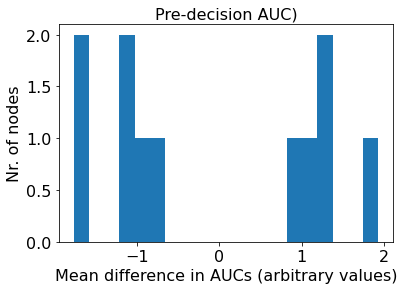

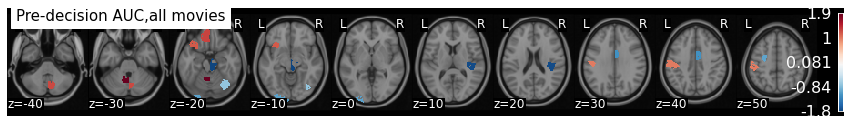

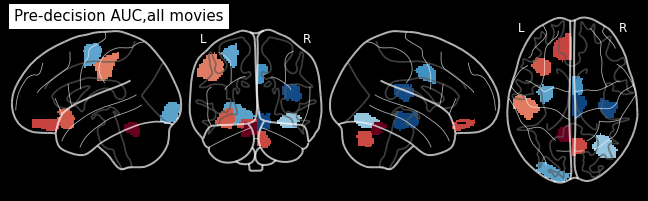

In [182]:
# pre-decision AUC
#all MOVIES 
mean_diff = np.empty((268,))
mean_diff [:] = np.nan
p  = np.empty_like(mean_diff)
p[:] = np.nan
#tr_dec =8

for n in range(268):
    if n % 50 ==0:
        print('node:',n)
    
    tc1 = tcs_trial_resh_yes_matched[subs1,n,:int(tr0_ind+tr_dec)]
    tc2 = tcs_trial_resh_no_matched[subs2,n,:int(tr0_ind+tr_dec)]
    auc1 = [np.trapz(tc1[s,:]) for s in range(tc1.shape[0])]
    auc2 = [np.trapz(tc2[s,:]) for s in range(tc2.shape[0])]
    mean_diff[n] = np.nanmean(auc1)-np.nanmean(auc2)
    _,p[n] = stats.ttest_ind(auc1,auc2)            

mean_diff[p>.05] = np.nan  
print('nr of nodes:',len(np.where(p<=.05)[0]))   

plt.hist(mean_diff,bins=20)
plt.xlabel('Mean difference in AUCs (arbitrary values)')
plt.ylabel('Nr. of nodes')
plt.title('Pre-decision AUC)')


img = roi_to_brain(pd.Series(mean_diff), mask_x)
txt = f"Pre-decision AUC,all movies"
img.plot(colorbar=True, title = txt,symmetric_cbar = False,cmap = 'RdBu_r')
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                 display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')

mean_diff_all.append(['all_matched',mean_diff])

In [187]:
np.where(~np.isnan(mean_diff_all[1][1]))

(array([  0,   3,  27,  37,  58, 114, 117, 151, 160, 163, 172, 202, 209,
        240]),)

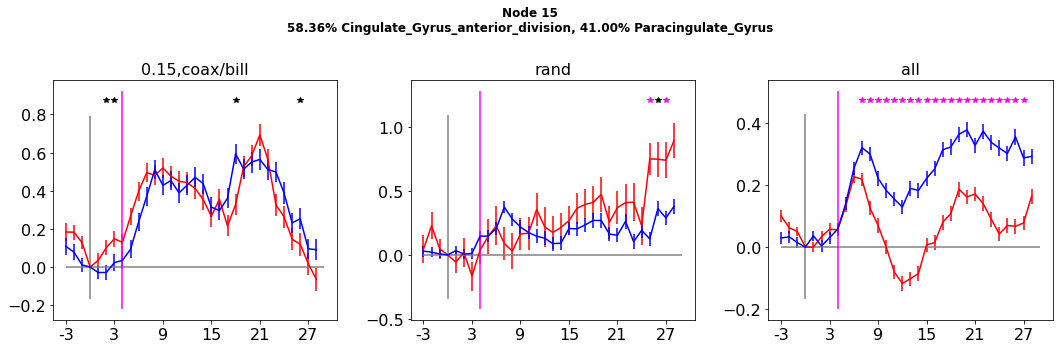

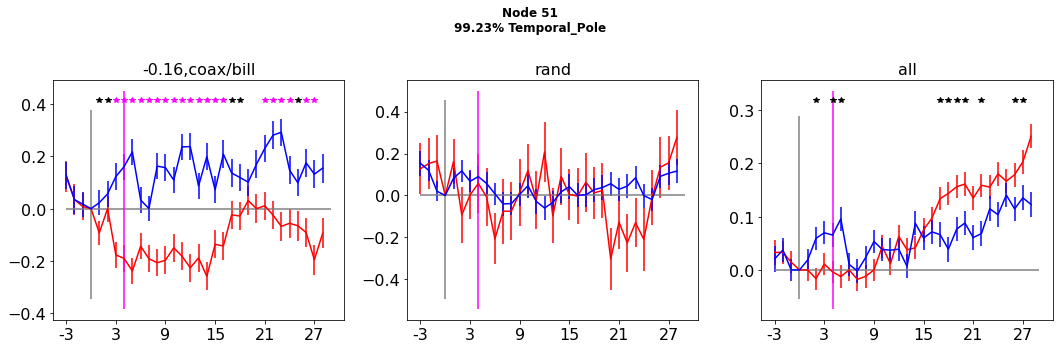

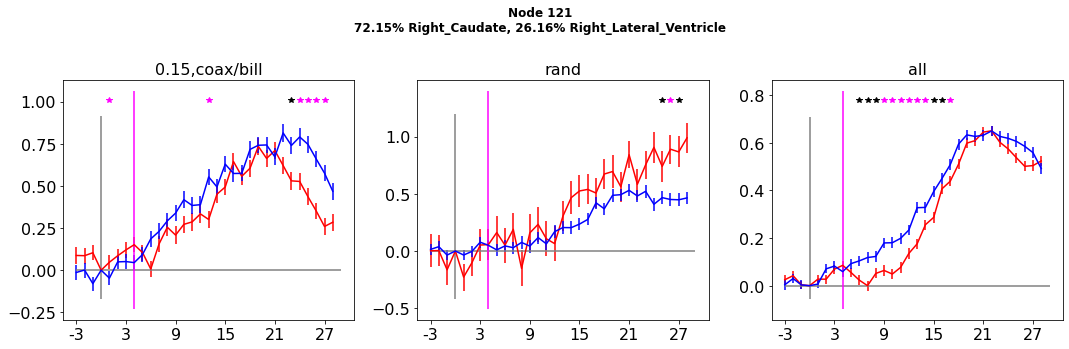

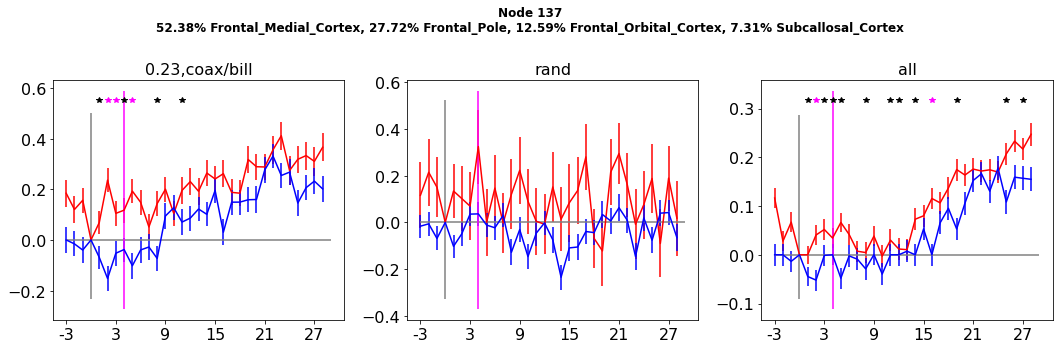

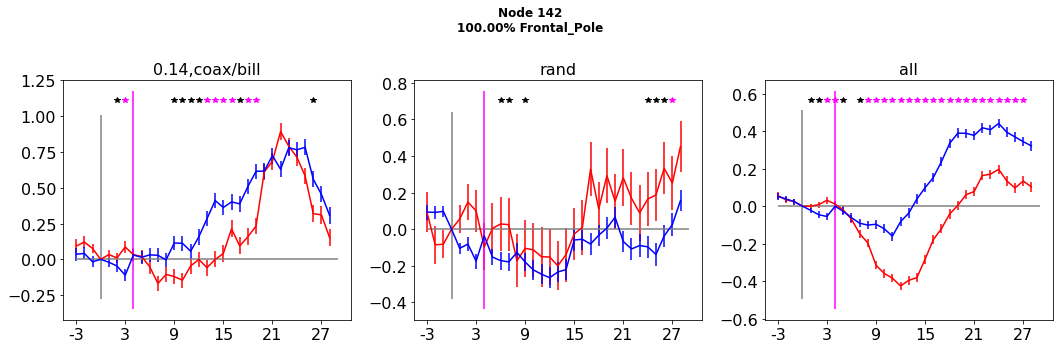

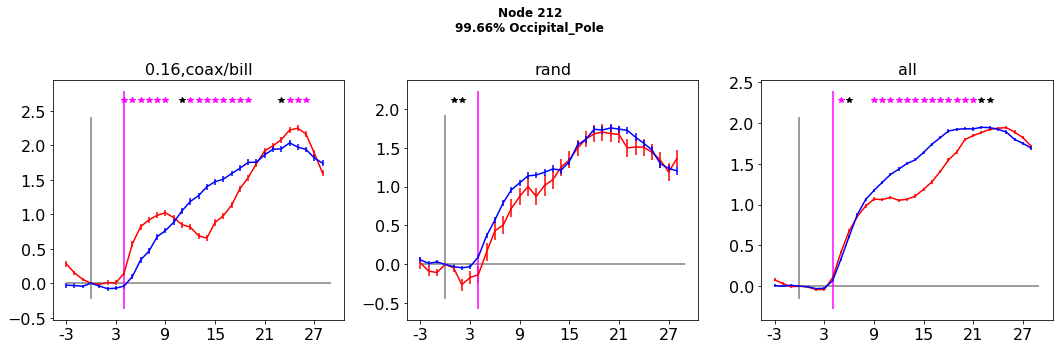

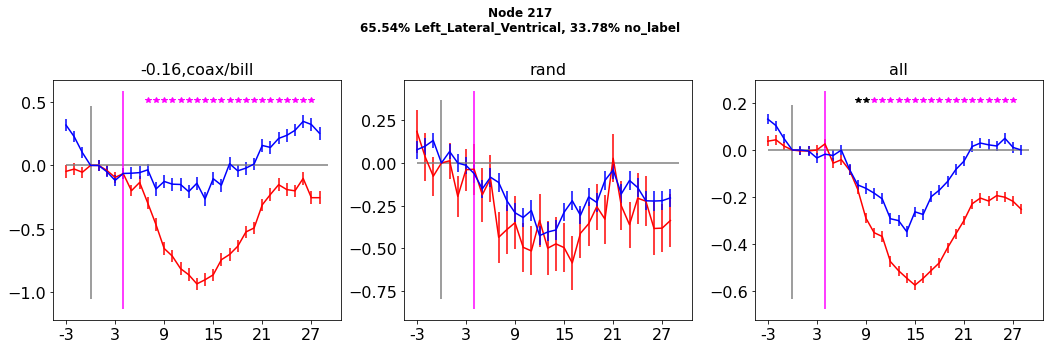

In [175]:
# plot same, diff and all movie timecourses for rois showing a difference in auc pre-decision
# to add in this, tc across all movies (yes vs. no)
# plotting timecourses of movies showing divergences at tr ~=3.5s
for i,n in enumerate(nodes):
    
    plt.figure(i,figsize = (15,5))
    
    #plt.title('Node '+ str(n+1))
    tc1 = tcs_trial_z[:,n,:,movie_ind_yes]
    tc2 = tcs_trial_z[:,n,:,movie_ind_no]
    plt.subplot(1,3,1)
    tmt.ttest_diffmovies(tc1,tc2,1,'both',0,tr0_ind)
    ymin,ymax =plt.ylim()
    plt.vlines(4+tr0_ind,ymin,ymax,color = 'magenta')
    plt.title(str(np.round(mean_diff[n],2)) + ',coax/bill')
    
    
    tc1 = tcs_run_z[subs1,n,:,movie_ind_same]
    tc2 = tcs_run_z[subs2,n,:,movie_ind_same]
    plt.subplot(1,3,2)
    tmt.ttest_samemovies(tc1,tc2,1,'both',0,tr0_ind)
    ymin,ymax =plt.ylim()
    plt.vlines(4+tr0_ind,ymin,ymax,color = 'magenta')
    plt.title('rand')
    
    tc1 = tcs_trial_resh_yes[:,n,:]
    tc2 = tcs_trial_resh_no[:,n,:]
    plt.subplot(1,3,3)
    tmt.ttest_samemovies(tc1,tc2,1,'both',0,tr0_ind)
    ymin,ymax =plt.ylim()
    plt.vlines(4+tr0_ind,ymin,ymax,color = 'magenta')
    plt.title('all')
    roi = eval(shen268[str(int(n+1))][0])['name'].split(';')
    #print(n+1,roi)
    plt.suptitle('Node '+ str(n+1) + '\n' + ','.join(roi),
                 fontweight = 'bold',fontsize = 12)
    
    plt.tight_layout()

## post-decision AUCs

node: 0
node: 50
node: 100
node: 150
node: 200
node: 250
nr of nodes: 164


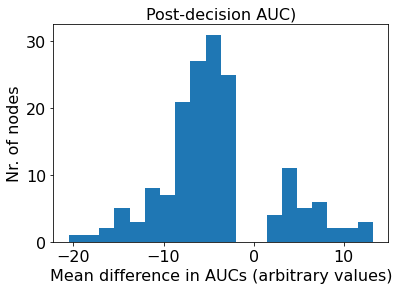

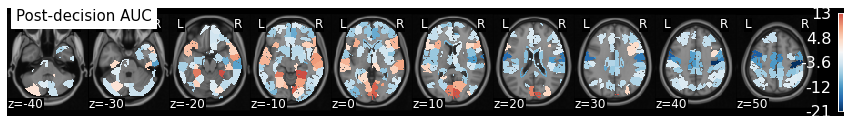

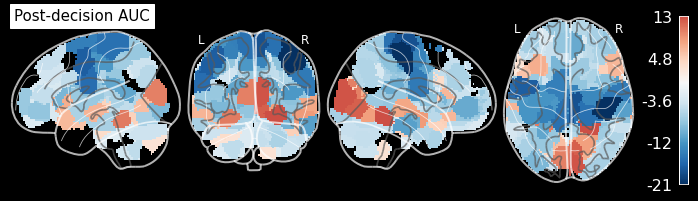

In [42]:
# post-decision AUC
#DIFF MOVIES 
mean_diff_aucs_post = np.empty((268,4))
mean_diff_aucs_post[:] = np.nan
mean_diff = np.empty((268,))
mean_diff [:] = np.nan
p  = np.empty_like(mean_diff)
p[:] = np.nan
tr_dec =5

for n in range(268):
    if n % 50 ==0:
        print('node:',n)
    
    diff_12 = (tcs_trial_z[:,n,int(tr0_ind+tr_dec):,movie_ind_yes]-\
                tcs_trial_z[:,n,int(tr0_ind+tr_dec):,movie_ind_no])
    auc1 = np.array([np.trapz(diff_12[s,:]) for s in range(tcs_trial_z.shape[0])])
    mean_diff[n] = np.nanmean(auc1)
    _,p[n] = stats.ttest_1samp(auc1,0)            

mean_diff_aucs_post[:,0] = mean_diff
mean_diff[p>.05] = np.nan  
print('nr of nodes:',len(np.where(p<=.05)[0]))   

plt.hist(mean_diff,bins=20)
plt.xlabel('Mean difference in AUCs (arbitrary values)')
plt.ylabel('Nr. of nodes')
plt.title('Post-decision AUC)')


img = roi_to_brain(pd.Series(mean_diff), mask_x)
txt = f"Post-decision AUC"
img.plot(colorbar=True, title = txt,symmetric_cbar = False,cmap = 'RdBu_r')
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,colorbar=True,
                 display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')

pre to post: SpearmanrResult(correlation=0.24962354314738383, pvalue=7.058270551838594e-05)
during to post: SpearmanrResult(correlation=0.41676896001177016, pvalue=1.0999547753264844e-12)


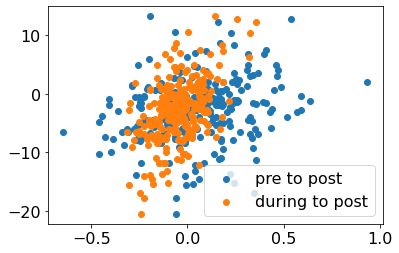

In [51]:
plt.scatter(mean_diff_aucs[:,0],mean_diff_aucs_post[:,0], label = 'pre to post')
print('pre to post:',stats.spearmanr(mean_diff_aucs[:,0],mean_diff_aucs_post[:,0],nan_policy='omit'))

plt.scatter(mean_diff_all_during[:,0],mean_diff_aucs_post[:,0], label = 'during to post')
print('during to post:',stats.spearmanr(mean_diff_all_during[:,0],mean_diff_aucs_post[:,0],nan_policy='omit'))

plt.legend()



In [ ]:


for i,n in enumerate(nodes):
    
    plt.figure(i,figsize = (10,5))
    
    #plt.title('Node '+ str(n+1))
    tc1 = tcs_trial_z[:,:,:,movie_ind_yes]
    tc2 = tcs_trial_z[:,:,:,movie_ind_no]
    plt.subplot(1,2,1)
    tmt.ttest_diffmovies(tc1[:,n,:],tc2[:,n,:],1,'both',0,tr0_ind)
    ymin,ymax =plt.ylim()
    plt.vlines(5+tr0_ind,ymin,ymax,color = 'magenta')
    plt.title(str(np.round(mean_diff[n],2)) + ',coax/bill')
    
    
    tc1 = tcs_run_z[subs1,:,:,movie_ind_same]
    tc2 = tcs_run_z[subs2,:,:,movie_ind_same]
    plt.subplot(1,2,2)
    tmt.ttest_samemovies(tc1[:,n,:],tc2[:,n,:],1,'both',0,tr0_ind)
    ymin,ymax =plt.ylim()
    plt.vlines(19+tr0_ind,ymin,ymax,color = 'magenta')
    plt.title('rand')
    
    roi = eval(shen268[str(int(n+1))][0])['name'].split(';')
    #print(n+1,roi)
    plt.suptitle('Node '+ str(n+1) + ',\n'+'\n'.join(roi),
                 fontweight = 'bold',fontsize = 12)
    
    plt.tight_layout()

node: 0
node: 50
node: 100
node: 150
node: 200
node: 250
nr of nodes: 62


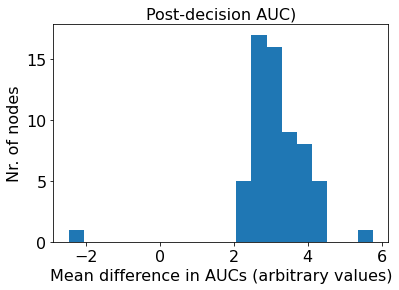

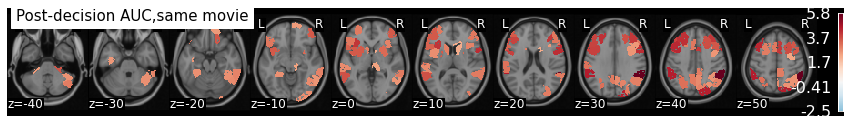

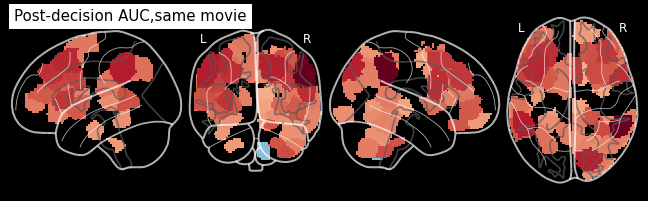

In [46]:
# post-decision AUC
#SAME MOVIES 
mean_diff = np.empty((268,))
mean_diff [:] = np.nan
p  = np.empty_like(mean_diff)
p[:] = np.nan
tr_dec =19 # later TR for decision

for n in range(268):
    if n % 50 ==0:
        print('node:',n)
    
    tc1 = tcs_run_z[subs1,n,int(tr0_ind+tr_dec):,movie_ind_same]
    tc2 = tcs_run_z[subs2,n,int(tr0_ind+tr_dec):,movie_ind_same]
    auc1 = [np.trapz(tc1[s,:]) for s in range(tc1.shape[0])]
    auc2 = [np.trapz(tc2[s,:]) for s in range(tc2.shape[0])]
    mean_diff[n] = np.nanmean(auc1)-np.nanmean(auc2)
    _,p[n] = stats.ttest_ind(auc1,auc2)            

mean_diff_aucs_post[:,1] = mean_diff
mean_diff[p>.05] = np.nan  
print('nr of nodes:',len(np.where(p<=.05)[0]))   


plt.hist(mean_diff,bins=20)
plt.xlabel('Mean difference in AUCs (arbitrary values)')
plt.ylabel('Nr. of nodes')
plt.title('Post-decision AUC)')


img = roi_to_brain(pd.Series(mean_diff), mask_x)
txt = f"Post-decision AUC,same movie"
img.plot(colorbar=True, title = txt,symmetric_cbar = False,cmap = 'RdBu_r')
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                 display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')

pre to post: SpearmanrResult(correlation=0.369938681197298, pvalue=1.8441840113085013e-09)
during to post: SpearmanrResult(correlation=0.3932097999622205, pvalue=2.4229290248875815e-11)


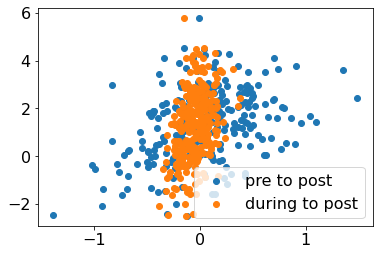

In [52]:
t = 1
plt.scatter(mean_diff_aucs[:,t],mean_diff_aucs_post[:,t], label = 'pre to post')
print('pre to post:',stats.spearmanr(mean_diff_aucs[:,t],mean_diff_aucs_post[:,t],nan_policy='omit'))

plt.scatter(mean_diff_all_during[:,t],mean_diff_aucs_post[:,t], label = 'during to post')
print('during to post:',stats.spearmanr(mean_diff_all_during[:,t],mean_diff_aucs_post[:,t],nan_policy='omit'))

plt.legend()



node: 0
node: 50
node: 100
node: 150
node: 200
node: 250
nr of nodes: 94


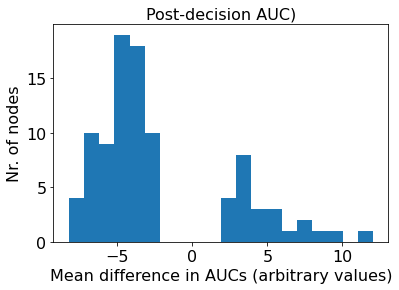

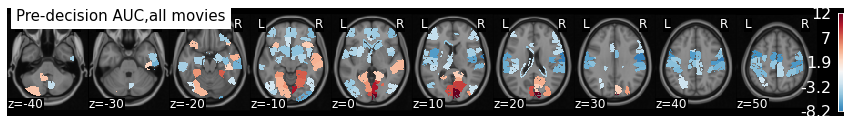

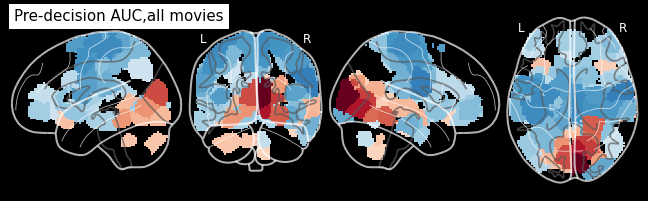

In [55]:
# post-decision AUC
#all MOVIES 
mean_diff = np.empty((268,))
mean_diff [:] = np.nan
p  = np.empty_like(mean_diff)
p[:] = np.nan
#tr_dec =8

for n in range(268):
    if n % 50 ==0:
        print('node:',n)
    
    tc1 = tcs_trial_resh_yes[subs1,n,int(tr0_ind+tr_dec):]
    tc2 = tcs_trial_resh_no[subs2,n,int(tr0_ind+tr_dec):]
    auc1 = [np.trapz(tc1[s,:]) for s in range(tc1.shape[0])]
    auc2 = [np.trapz(tc2[s,:]) for s in range(tc2.shape[0])]
    mean_diff[n] = np.nanmean(auc1)-np.nanmean(auc2)
    _,p[n] = stats.ttest_ind(auc1,auc2)            

mean_diff_aucs_post[:,2] = mean_diff
mean_diff[p>.05] = np.nan  
print('nr of nodes:',len(np.where(p<=.05)[0]))   

plt.hist(mean_diff,bins=20)
plt.xlabel('Mean difference in AUCs (arbitrary values)')
plt.ylabel('Nr. of nodes')
plt.title('Post-decision AUC)')


img = roi_to_brain(pd.Series(mean_diff), mask_x)
txt = f"Pre-decision AUC,all movies"
img.plot(colorbar=True, title = txt,symmetric_cbar = False,cmap = 'RdBu_r')
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                 display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')

pre to post: SpearmanrResult(correlation=-0.06305278578070936, pvalue=0.32270024287574517)
during to post: SpearmanrResult(correlation=0.30587944118844396, pvalue=3.273417355292456e-07)


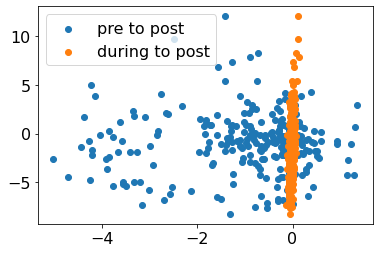

In [56]:
t = 2
plt.scatter(mean_diff_aucs[:,t],mean_diff_aucs_post[:,t], label = 'pre to post')
print('pre to post:',stats.spearmanr(mean_diff_aucs[:,t],mean_diff_aucs_post[:,t],nan_policy='omit'))

plt.scatter(mean_diff_all_during[:,t],mean_diff_aucs_post[:,t], label = 'during to post')
print('during to post:',stats.spearmanr(mean_diff_all_during[:,t],mean_diff_aucs_post[:,t],nan_policy='omit'))

plt.legend()



## THINK WHAT TO DO NEXT OR WHERE TO GO NEXT. - AFTER SEPT 23!!

In [48]:
tmedian = np.empty((268,))
tmedian[:] = np.nan
pmedian = np.empty_like(tmedian)
pmedian[:] = np.nan
median_diff = np.empty_like(tmedian)
median_diff[:] = np.nan
yes_no_sign = np.empty_like(tmedian)
yes_no_sign[:] = np.nan
for n in range(268):
    tmedian[n],pmedian[n] = \
        stats.ttest_rel(movie_tc_yes[:,n,int(t_TRs_ind[1])],
                        movie_tc_no[:,n,int(t_TRs_ind[1])],nan_policy='omit')
    yes_med = np.nanmedian(movie_tc_yes[:,n,int(t_TRs_ind[1])])
    no_med = np.nanmedian(movie_tc_no[:,n,int(t_TRs_ind[1])])
                           
    median_diff[n] = yes_med - no_med
    if abs(abs(yes_med) - abs(no_med)) > 1e-5:
        if abs(yes_med) > abs(no_med):
               yes_no_sign[n] = 1
        elif abs(yes_med) < abs(no_med):
                yes_no_sign[n] = -1
    else:
        yes_no_sign[n] = 0
        

- from the figure above (red = median social > nonsocial, color indicatesthe magnitude of differnce), it looks like most of the diffs at t approx.= 3secs is negative, i.e, social <nonsocial. Is this due to a dip in social or activation in random? let's compare absolute values at this point next.

- from the figure above (red = abs. median social > nonsocial, color indicates the magnitude of difference), it looks like a lot of the diffs at t approx.= 3secs is due to a higher magnitude for random but some are also due to social (red)

- red: mag social > nonsocial and vice versa

- previous and this figure together: most of the blue nodes are where there is a higher positive activation for billiards


In [192]:
np.where(ts_all[0][n] == int(t_TRs_ind[1])-1)[0]



array([], dtype=int64)

In [199]:
n=32

if ((len(np.where(ts_all[0][n][0] == int(t_TRs_ind[1]-tr0_ind)-1)[0])==0) and \
    (len(np.where(ts_all[0][n][0] == int(t_TRs_ind[1]-tr0_ind)+1)[0])==0)):
    print('in')

In [202]:
tmedian = np.empty((268,))
tmedian[:] = np.nan
pmedian = np.empty_like(tmedian)
pmedian[:] = np.nan
median_diff = np.empty_like(tmedian)
median_diff[:] = np.nan
yes_no_sign = np.empty_like(tmedian)
yes_no_sign[:] = np.nan
for n in range(268):
    tmedian[n],pmedian[n] = \
        stats.ttest_rel(movie_tc_yes[:,n,int(t_TRs_ind[1])],
                        movie_tc_no[:,n,int(t_TRs_ind[1])],nan_policy='omit')
    yes_med = np.nanmedian(movie_tc_yes[:,n,int(t_TRs_ind[1])])
    no_med = np.nanmedian(movie_tc_no[:,n,int(t_TRs_ind[1])])
                           
    median_diff[n] = yes_med - no_med
    if abs(abs(yes_med) - abs(no_med)) > 1e-5:
        if abs(yes_med) > abs(no_med):
               yes_no_sign[n] = 1
        elif abs(yes_med) < abs(no_med):
                yes_no_sign[n] = -1
    else:
        yes_no_sign[n] = 0

#consistentsy test:

for n in np.where(pmedian <.05)[0]:
    if ((len(np.where(ts_all[0][n][0] == int(t_TRs_ind[1]-tr0_ind)-1)[0])==0) and \
        (len(np.where(ts_all[0][n][0] == int(t_TRs_ind[1]-tr0_ind)+1)[0])==0)):
        pmedian[n] =np.nan
        tmedian[n] = np.nan
        
print(np.where(pmedian<.05))

tdiv_med = np.empty((268,))
tdiv_med[:] = np.nan
sign_diff = np.empty((268,))
sign_diff[:] = np.nan
ct = 1
for n in np.where(pmedian<.05)[0]:
    TRs = np.arange(1, max(t_TRs_ind))
    TRs = TRs[::-1]
    #print(TRs)
    supra_thresh_ct = 0
    for t in TRs:
        t = int(t)
        _, pval = stats.ttest_rel(movie_tc_yes[:,n,t],
                        movie_tc_no[:,n,t],nan_policy='omit')
        #print(n,t,pval)
        sign_diff = 1 if np.sign(np.nanmedian(movie_tc_yes[:,n,t]-movie_tc_no[:,n,t])) == \
        np.sign(np.nanmedian(movie_tc_yes[:,n,int(min(t_TRs_ind))]-movie_tc_no[:,n,int(min(t_TRs_ind))])) \
        else -1
        #print(t,pval,sign_diff)
        if (pval >= .05) | (sign_diff==-1):
            supra_thresh_ct += 1
        if supra_thresh_ct == ct:
            tdiv_med[n] = t+ct
            break
    
        
tdiv_med -= 3
tdiv_med

(array([  8,  12,  20,  22,  23,  24,  25,  26,  32,  33,  34,  36,  37,
        38,  39,  40,  41,  43,  44,  45,  50,  51,  53,  56,  62,  64,
        65,  66,  67,  68,  70,  71,  72,  73,  78,  79,  80,  81,  86,
        96,  99, 104, 110, 111, 113, 115, 121, 125, 136, 137, 142, 154,
       157, 158, 159, 161, 162, 164, 167, 169, 171, 172, 173, 174, 179,
       180, 182, 191, 199, 204, 205, 207, 208, 209, 210, 211, 212, 213,
       214, 215, 217, 222, 224, 225, 235, 237, 240, 241, 245, 246, 249,
       251, 252, 253, 256, 259]),)


array([nan, nan, nan, nan, nan, nan, nan, nan,  5., nan, nan, nan,  5.,
       nan, nan, nan, nan, nan, nan, nan,  2., nan,  3.,  3.,  5.,  5.,
        2., nan, nan, nan, nan, nan,  2.,  5.,  4., nan,  5.,  4.,  5.,
        4.,  4.,  5., nan,  5.,  4.,  2., nan, nan, nan, nan,  1.,  2.,
       nan,  1., nan, nan,  5., nan, nan, nan, nan, nan,  5., nan,  2.,
        2.,  2.,  4.,  3., nan,  1.,  4.,  5.,  3., nan, nan, nan, nan,
        4.,  4.,  3.,  4., nan, nan, nan, nan,  4., nan, nan, nan, nan,
       nan, nan, nan, nan, nan,  5., nan, nan,  5., nan, nan, nan, nan,
        3., nan, nan, nan, nan, nan,  3.,  4., nan,  5., nan,  5., nan,
       nan, nan, nan, nan,  5., nan, nan, nan,  5., nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan,  2.,  5., nan, nan, nan, nan,  2.,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  5., nan,
       nan,  5.,  3.,  4., nan,  2.,  4., nan,  3., nan, nan,  3., nan,
        5., nan,  4.,  5.,  4.,  4., nan, nan, nan, nan,  3.,  3

- here we can see that although several nodes show Yes> No in the end, there is often a yes-to-no flip (e.g. yes>no at t=28, but no>yes at t=10). To identify these and other diffs, next analyses:

1. identify accumulators, deciders etc. using all movies' data
2. use these labels to split nodes
3. also split nodes where activity flips from no>yes to yes>no

# Extra code

In [ ]:
n=14
tc1 = tcs_trial_z[:,n,:int(tr0_ind+tr_dec),movie_ind_yes]
tc2 = tcs_trial_z[:,n,:int(tr0_ind+tr_dec),movie_ind_no]
auc1 = np.array([np.trapz(tc1[s,:]) for s in range(tc1.shape[0])])
auc2 = np.array([np.trapz(tc2[s,:]) for s in range(tc2.shape[0])])
mean_difference = np.nanmean(auc1-auc2)
_,pval = stats.ttest_rel(auc1,auc2)

# not sure what this was for exactly..